<a href="https://colab.research.google.com/github/Fatin817/CODSOFT/blob/main/Movie_genre_classification_(Task_1)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup and libraries**

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [1]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00
time: 252 µs (started: 2024-06-08 03:22:02 +00:00)


In [65]:
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import keras
import re
import os
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional,Masking,SpatialDropout1D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC


time: 1.51 ms (started: 2024-06-08 04:30:31 +00:00)


## **Text to CSV convert**

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive
time: 26.7 s (started: 2024-06-08 03:22:07 +00:00)


In [ ]:
file_path = '/content/drive/MyDrive/Moviegenreclassification/test_data_solution.txt'

with open(file_path, 'r') as files:
    content = files.read()

lines = content.strip().split('\n')

titles = []
genres = []
descriptions = []

for line in lines:
    parts = line.split(' ::: ')
    if len(parts) == 4:
        movie_id, title,genre, description = parts
        titles.append(title.strip())
        genres.append(genre.strip())
        descriptions.append(description.strip())

df = pd.DataFrame({
    'title': titles,
    'genre': genres,
    'description': descriptions
})

print(df)

                                title        genre  \
0                Edgar's Lunch (1998)     thriller   
1            La guerra de papá (1977)       comedy   
2         Off the Beaten Track (2010)  documentary   
3              Meu Amigo Hindu (2015)        drama   
4                   Er nu zhai (1955)        drama   
...                               ...          ...   
54195  "Tales of Light & Dark" (2013)       horror   
54196     Der letzte Mohikaner (1965)      western   
54197             Oliver Twink (2007)        adult   
54198               Slipstream (1973)        drama   
54199       Curitiba Zero Grau (2010)        drama   

                                             description  
0      L.R. Brane loves his life - his car, his apart...  
1      Spain, March 1964: Quico is a very naughty chi...  
2      One year in the life of Albin and his family o...  
3      His father has died, he hasn't spoken with his...  
4      Before he was known internationally as a marti...

In [ ]:
len(titles) , len(descriptions)

(54200, 54200)

time: 4.17 ms (started: 2024-06-06 05:51:35 +00:00)


In [ ]:
csv_path = '/content/drive/MyDrive/Moviegenreclassification/test_data_solution.csv'

df.to_csv(csv_path, index=False)

time: 1.28 s (started: 2024-06-06 06:06:51 +00:00)


## **Preprocess dataset**

In [4]:

dataset_path = '/content/drive/MyDrive/Moviegenreclassification/train_data.csv'
df = pd.read_csv(dataset_path)

X = df['description']
Y = df['genre']

print(X.value_counts())
print(Y.value_counts())


description
Grammy - music award of the American academy of the audio recording, was founded by the American association of sound-recording companies of March, 14, 1958. Grammy is awarded annually as a result of voting by the authorized members of "Recording Academy".                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

<Axes: ylabel='genre'>

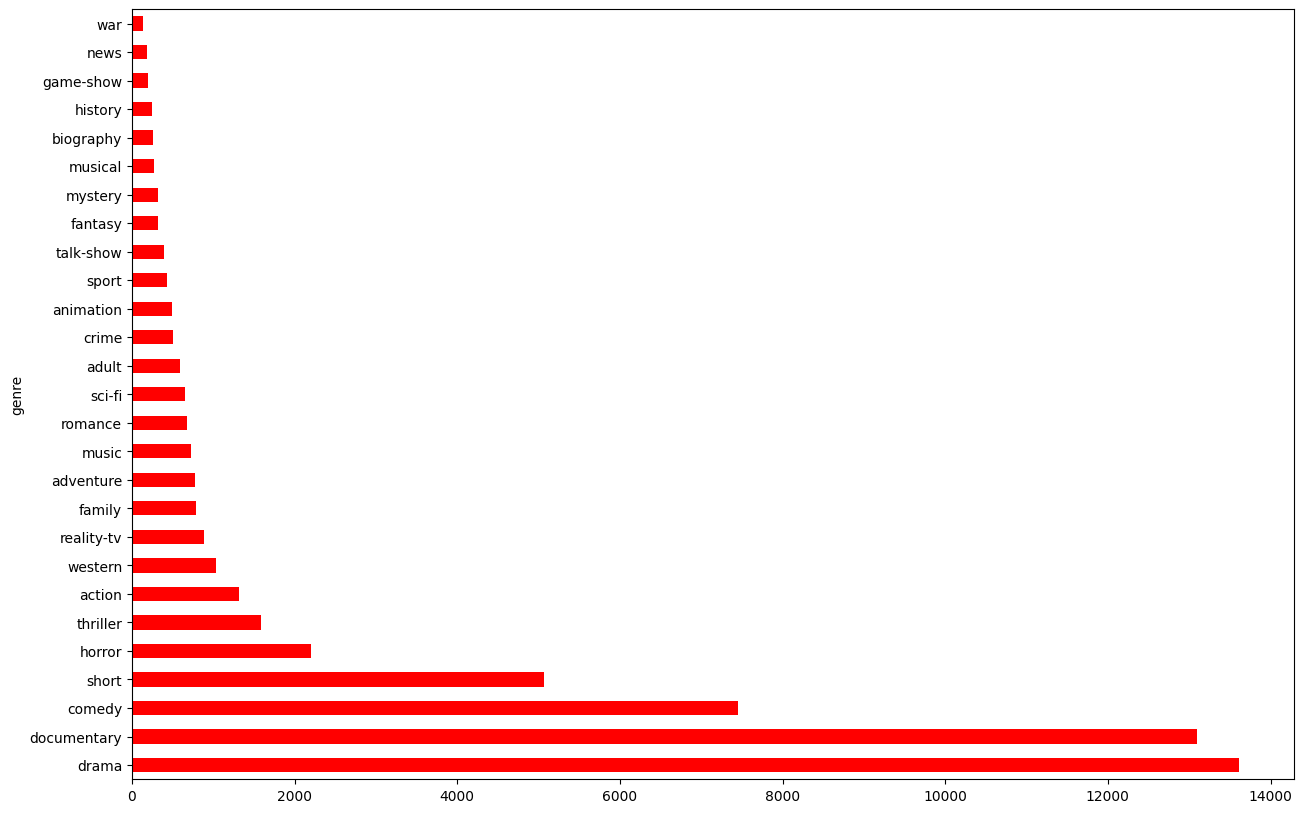

time: 424 ms (started: 2024-06-07 14:47:14 +00:00)


In [ ]:
Y.value_counts().plot(kind="barh",figsize=(15,10),color='red')

In [5]:
len(X) ,len(Y)

(54214, 54214)

time: 14.5 ms (started: 2024-06-08 03:22:39 +00:00)


In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(X)

time: 6.1 s (started: 2024-06-07 15:42:10 +00:00)


In [51]:
Y = pd.get_dummies(df['genre'],dtype=int).values
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

time: 23.2 ms (started: 2024-06-08 03:41:30 +00:00)


In [6]:
LB = LabelEncoder()

time: 429 µs (started: 2024-06-08 03:22:39 +00:00)


In [7]:

Y = LB.fit_transform(Y)
print(Y)

[ 8 24  1 ...  7  5 12]
time: 65.9 ms (started: 2024-06-08 03:22:39 +00:00)


In [8]:

decoded_genres = LB.inverse_transform(Y)
print("Decoded genres:", decoded_genres)

Decoded genres: ['drama' 'thriller' 'adult' ... 'documentary' 'comedy' 'history']
time: 17.9 ms (started: 2024-06-08 03:22:40 +00:00)


In [9]:
Y.shape

(54214,)

time: 10.6 ms (started: 2024-06-08 03:22:40 +00:00)


In [10]:
stopwords = set([
    'a', 'an', 'the', 'and', 'or', 'but', 'if', 'in', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'to', 'from', 'of', 'on', 'off',
    'over', 'under', 'than', 'so', 'such', 'as', 'is', 'are', 'was', 'were',
    'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can',
    'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must'
])
def clean_text(text):
    text = text.lower() #lower
    text = re.sub(r'\d+', '', text) # number
    text = re.sub(r'\s+', ' ', text) #extra whitespace
    text = re.sub(r'[^\w\s]', '', text) # punctuation
    text = text.strip() #l eading and trailing whitespace
    text = ' '.join(word for word in text.split() if word not in stopwords) # stopwords
    text = re.sub(r'[^\x00-\x7F]+', '', text) #unicode characters
    return text

X= [clean_text(text) for text in X]


time: 23.1 s (started: 2024-06-08 03:22:40 +00:00)


In [11]:
X= np.array(X)
X

array(['listening conversation his doctor parents yearold oscar learns what nobody courage tell him he only few weeks live furious he refuses speak anyone except straighttalking rose lady pink he meets hospital stairs christmas approaches rose uses her fantastical experiences professional wrestler her imagination wit charm allow oscar live life love full company his friends pop corn einstein bacon childhood sweetheart peggy blue',
       'brother sister past incestuous relationship current murderous relationship he murders women who reject him she murders women who get too close him',
       'bus empties students their field trip museum natural history little tour guide suspect that students there more just another tour first during lecture films coeds drift into dreams most erotic fantasies one imagine after films they release emotion fantasies most erotic uncommon ways one slips curators office little acquisition another finds anthropologist see what bones identified even head teache

time: 1.95 s (started: 2024-06-08 03:23:03 +00:00)


***For vector and forest***

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0., random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((37949, 5000), (16265, 5000), (37949,), (16265,))

time: 63.1 ms (started: 2024-06-07 15:42:37 +00:00)


***For our network train***

In [52]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((43371,), (10843,), (43371, 27), (10843, 27))

time: 1.56 s (started: 2024-06-08 03:41:40 +00:00)


In [54]:
X_train[1], X_val[0]

('autistic teen tony his friendship cameron boy who still trying deal death his mother through friendship love compassion boundaries overcome two boys fill their summer timeless relationship that shows that friendship overcomes all',
 'catherine stjohnburke independent uptight status obsessed sophisticated british woman living alone londons chelsea doing herself no favors having affair married man her world turned upside down when she comes home one day discover uneducated kiwi woman very hairy legs drinking beer her living room shirley zachary claims catherines long lost halfsister that their father who catherine thought died when she child still alive trying make claims both their properties following death their mothers furious frustrated shirleys refusal disappear shirley reluctantly agrees undertake dna test catherines horror results concludes that they indeed related both girls agree work together track down their conman trapped s father order get rightful ownership their inherit

time: 3.08 ms (started: 2024-06-08 03:42:00 +00:00)


In [55]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
print(X_train[1])
print(X_val[0])

[1753, 1231, 1, 488, 4600, 174, 6, 166, 202, 491, 99, 1, 71, 36, 488, 29, 3424, 3057, 1018, 27, 356, 4202, 5, 482, 161, 4, 216, 4, 488, 15]
[3751, 1104, 1819, 1583, 616, 67, 120, 397, 542, 224, 62, 198, 642, 213, 34, 2, 24, 621, 2113, 111, 11, 8, 128, 51, 13, 52, 270, 67, 108, 4975, 1565, 2955, 2, 120, 400, 4971, 1599, 155, 201, 4, 5, 57, 6, 3751, 724, 630, 11, 8, 196, 166, 767, 202, 66, 1599, 87, 5, 387, 99, 5, 678, 4170, 2535, 3686, 4971, 2883, 1208, 4746, 942, 770, 1352, 4, 7, 2945, 2891, 87, 223, 2861, 75, 90, 1197, 111, 5, 1203, 135, 57, 199, 44, 5, 3781, 420, 1687, 142, 1859, 385, 21, 1044, 34, 42, 7, 416, 387, 34, 244, 2212, 1248, 986]
time: 10.9 s (started: 2024-06-08 03:42:01 +00:00)


In [56]:
len(X_train) , len(X_val)

(43371, 10843)

time: 2.59 ms (started: 2024-06-08 03:42:12 +00:00)


In [57]:
max_length = 200
X_train= pad_sequences(X_train, maxlen=max_length, padding='post')
X_val= pad_sequences(X_val, maxlen=max_length, padding='post')
print(X_train[2])
print(X_val[3])

[4430  267 1098    9 4930 1844  313    4   68   80 3192 4519 3425 2103
 3426 1557   47    9  298  313    4  750   27  129 3978 1213  229  595
  439   24    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [58]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(43371, 200)
(10843, 200)
(43371, 27)
(10843, 27)
time: 983 µs (started: 2024-06-08 03:42:12 +00:00)


In [59]:
X_train, X_val, Y_train, Y_val

(array([[ 312, 2304, 1491, ...,    0,    0,    0],
        [1753, 1231,    1, ...,    0,    0,    0],
        [4430,  267, 1098, ...,    0,    0,    0],
        ...,
        [2312, 1198,  120, ...,    0,    0,    0],
        [   7, 1848,    5, ...,    0,    0,    0],
        [ 890, 2150,    1, ...,    0,    0,    0]], dtype=int32),
 array([[3751, 1104, 1819, ...,    0,    0,    0],
        [ 655,  411,  682, ...,    0,    0,    0],
        [ 140,  468,    4, ...,    0,    0,    0],
        ...,
        [ 351,  200,   67, ...,    0,    0,    0],
        [  67, 2537,    2, ...,    0,    0,    0],
        [   9, 1863,  173, ...,    0,    0,    0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
       

time: 6.17 ms (started: 2024-06-08 03:42:12 +00:00)


In [60]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def decode_text(encoded_text):
    return ' '.join([reverse_word_map.get(i, '?') for i in encoded_text])

for i in range(5):
    print(f"Decoded Text {i+1}: {decode_text(X_train[i])}")


Decoded Text 1: sex betrayal addiction love hate obsession words that brand each characters linda john each master each solitary convention time viewer down which we all few embrace darkness light exists that lives our characters ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Decoded Text 2: teen tony his friendship cameron boy who still trying deal death his mother through friendship love compassion boundaries overcome two boys fill their summer relationship that shows that friendship all ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

## **MODEL**

### **Model with Lebelencoder**

In [20]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(LB.classes_), activation='softmax'))

time: 2.1 s (started: 2024-06-08 03:23:41 +00:00)


In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 200, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 27)                8

In [23]:

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
    )


Epoch 1/50
678/678 [==============================] - 57s 70ms/step - loss: 2.4194 - accuracy: 0.2466 - val_loss: 2.3483 - val_accuracy: 0.2487
Epoch 2/50
678/678 [==============================] - 22s 33ms/step - loss: 2.3697 - accuracy: 0.2465 - val_loss: 2.3461 - val_accuracy: 0.2487
Epoch 3/50
678/678 [==============================] - 17s 25ms/step - loss: 2.3611 - accuracy: 0.2506 - val_loss: 2.3415 - val_accuracy: 0.2580
Epoch 4/50
678/678 [==============================] - 15s 23ms/step - loss: 2.3560 - accuracy: 0.2528 - val_loss: 2.3488 - val_accuracy: 0.2598
Epoch 5/50
678/678 [==============================] - 15s 22ms/step - loss: 2.3530 - accuracy: 0.2527 - val_loss: 2.3415 - val_accuracy: 0.2487
Epoch 6/50
678/678 [==============================] - 15s 22ms/step - loss: 2.3531 - accuracy: 0.2522 - val_loss: 2.3444 - val_accuracy: 0.2347
Epoch 7/50
678/678 [==============================] - 15s 22ms/step - loss: 2.3522 - accuracy: 0.2490 - val_loss: 2.3456 - val_accuracy:

### **Model without Lebelencoder**

In [62]:
model2 = Sequential()
model2.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model2.add(SpatialDropout1D(0.2))
model2.add(Bidirectional(LSTM(200,return_sequences=True, dropout=0.4)))
model2.add(Bidirectional(LSTM(200, dropout=0.4)))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(27, activation='softmax'))

time: 993 ms (started: 2024-06-08 04:16:14 +00:00)


In [63]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          640000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 200, 128)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 400)          526400    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 400)               961600    
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 400)               1600      
 chNormalization)                                     

In [64]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history2 = model2.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
    )


Epoch 1/50
678/678 [==============================] - 88s 118ms/step - loss: 1.9127 - accuracy: 0.4652 - val_loss: 1.8801 - val_accuracy: 0.4601
Epoch 2/50
678/678 [==============================] - 73s 107ms/step - loss: 1.5042 - accuracy: 0.5610 - val_loss: 1.8888 - val_accuracy: 0.4941
Epoch 3/50
678/678 [==============================] - 59s 87ms/step - loss: 1.3294 - accuracy: 0.6036 - val_loss: 1.7618 - val_accuracy: 0.4928
Epoch 4/50
678/678 [==============================] - 53s 79ms/step - loss: 1.2136 - accuracy: 0.6295 - val_loss: 1.8184 - val_accuracy: 0.4698
Epoch 5/50
678/678 [==============================] - 52s 77ms/step - loss: 1.1160 - accuracy: 0.6532 - val_loss: 1.5782 - val_accuracy: 0.5630
Epoch 6/50
678/678 [==============================] - 51s 75ms/step - loss: 1.0377 - accuracy: 0.6717 - val_loss: 1.7783 - val_accuracy: 0.5078
Epoch 7/50
678/678 [==============================] - 53s 78ms/step - loss: 0.9628 - accuracy: 0.6932 - val_loss: 1.7037 - val_accurac

### **Support Vector Machines**

In [ ]:
with tf.device('/device:GPU:0'):
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, Y_train)

time: 9min 30s (started: 2024-06-07 15:43:03 +00:00)


### **Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

time: 2min 15s (started: 2024-06-07 15:52:34 +00:00)


## **Evaluation**

In [70]:

dataset_path = '/content/drive/My Drive/Moviegenreclassification/test_data_solution.csv'
df2 = pd.read_csv(dataset_path)

X_test = df2['description']
Y_test  = df2['genre']


print(X_test .value_counts())
print(Y_test .value_counts())



description
Grammy - music award of the American academy of the audio recording, was founded by the American association of sound-recording companies of March, 14, 1958. Grammy is awarded annually as a result of voting by the authorized members of "Recording Academy".                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [71]:
len(X_test ) ,len(Y_test )

(54200, 54200)

time: 2.81 ms (started: 2024-06-08 04:31:09 +00:00)


In [72]:
Y_test = pd.get_dummies(df2['genre']).values

time: 17.7 ms (started: 2024-06-08 04:31:12 +00:00)


In [37]:

LB_eva = LabelEncoder()
Y_test  = LB_eva.fit_transform(Y_test )

print(Y_test )

[24  5  7 ...  1  8  8]
time: 13.1 ms (started: 2024-06-08 03:33:43 +00:00)


In [73]:
Y_test .shape

(54200, 27)

time: 3.17 ms (started: 2024-06-08 04:31:14 +00:00)


In [74]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_test )
X_test = tokenizer.texts_to_sequences(X_test )
print(X_test [1])


[2258, 2171, 7, 3, 143, 236, 4, 104, 4810, 5, 3, 535, 357, 462, 54, 261, 873, 11, 684, 11, 26, 237, 1, 1495, 4, 1298, 4, 1, 133, 12, 8, 1044, 621, 62, 258, 83, 9, 8, 191, 2808, 20, 7, 1044, 57, 62, 2, 7, 1003, 896, 16, 55, 4706, 45, 2358, 1, 2730, 2217, 4, 8, 106, 1, 2, 1, 62, 1, 811, 4, 1, 54, 393, 24, 50, 211, 797, 567, 8, 106, 2, 3, 81, 4, 1261, 25, 121, 57, 41, 1468, 2, 1, 988, 136, 13, 1454, 1, 1240, 4174, 7, 1593, 12, 16, 178, 136]
time: 8.94 s (started: 2024-06-08 04:31:16 +00:00)


In [75]:
len(X_test )

54200

time: 2.61 ms (started: 2024-06-08 04:31:25 +00:00)


In [76]:
max_length = 200
X_test = pad_sequences(X_test , maxlen=max_length, padding='post')
print(X_test [1])


[2258 2171    7    3  143  236    4  104 4810    5    3  535  357  462
   54  261  873   11  684   11   26  237    1 1495    4 1298    4    1
  133   12    8 1044  621   62  258   83    9    8  191 2808   20    7
 1044   57   62    2    7 1003  896   16   55 4706   45 2358    1 2730
 2217    4    8  106    1    2    1   62    1  811    4    1   54  393
   24   50  211  797  567    8  106    2    3   81    4 1261   25  121
   57   41 1468    2    1  988  136   13 1454    1 1240 4174    7 1593
   12   16  178  136    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [77]:
X_eva = np.array(X_test )
Y_eva = np.array(Y_test )
X_eva.shape, Y_eva.shape

((54200, 200), (54200, 27))

time: 58.4 ms (started: 2024-06-08 04:31:25 +00:00)


In [43]:
loss, accuracy = model.evaluate(X_eva, Y_eva)

1694/1694 [==============================] - 14s 8ms/step - loss: 3.3436 - accuracy: 0.2123
time: 20.6 s (started: 2024-06-08 03:33:57 +00:00)


In [79]:
loss, accuracy = model2.evaluate(X_eva, Y_eva)

1694/1694 [==============================] - 39s 21ms/step - loss: 3.6462 - accuracy: 0.2216
time: 43.9 s (started: 2024-06-08 04:31:59 +00:00)


## **Prediction**

In [80]:
test_dataset_path = '/content/drive/MyDrive/Moviegenreclassification/test_data_solution.csv'
test_df = pd.read_csv(test_dataset_path)

time: 739 ms (started: 2024-06-08 04:32:50 +00:00)


In [81]:
X2 = test_df['description']
Y2 = test_df['genre']

print(X2.value_counts())
print(Y2.value_counts())

description
Grammy - music award of the American academy of the audio recording, was founded by the American association of sound-recording companies of March, 14, 1958. Grammy is awarded annually as a result of voting by the authorized members of "Recording Academy".                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

***For vector and forest***

In [ ]:
tfidf_sol = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf_sol = tfidf.fit_transform(X2)
X_pre_sol, _ , Y_pre_sol, _= train_test_split(X_tfidf_sol, Y2, random_state=42)
X_pre_sol.shape,  Y_pre_sol.shape

((40650, 5000), (40650,))

time: 6 s (started: 2024-06-07 15:55:27 +00:00)


***For our train model***

In [82]:
X_sol_text = test_df['description'].tolist()
Y_sol = test_df['genre'].tolist()

time: 4.32 ms (started: 2024-06-08 04:32:59 +00:00)


<Axes: ylabel='genre'>

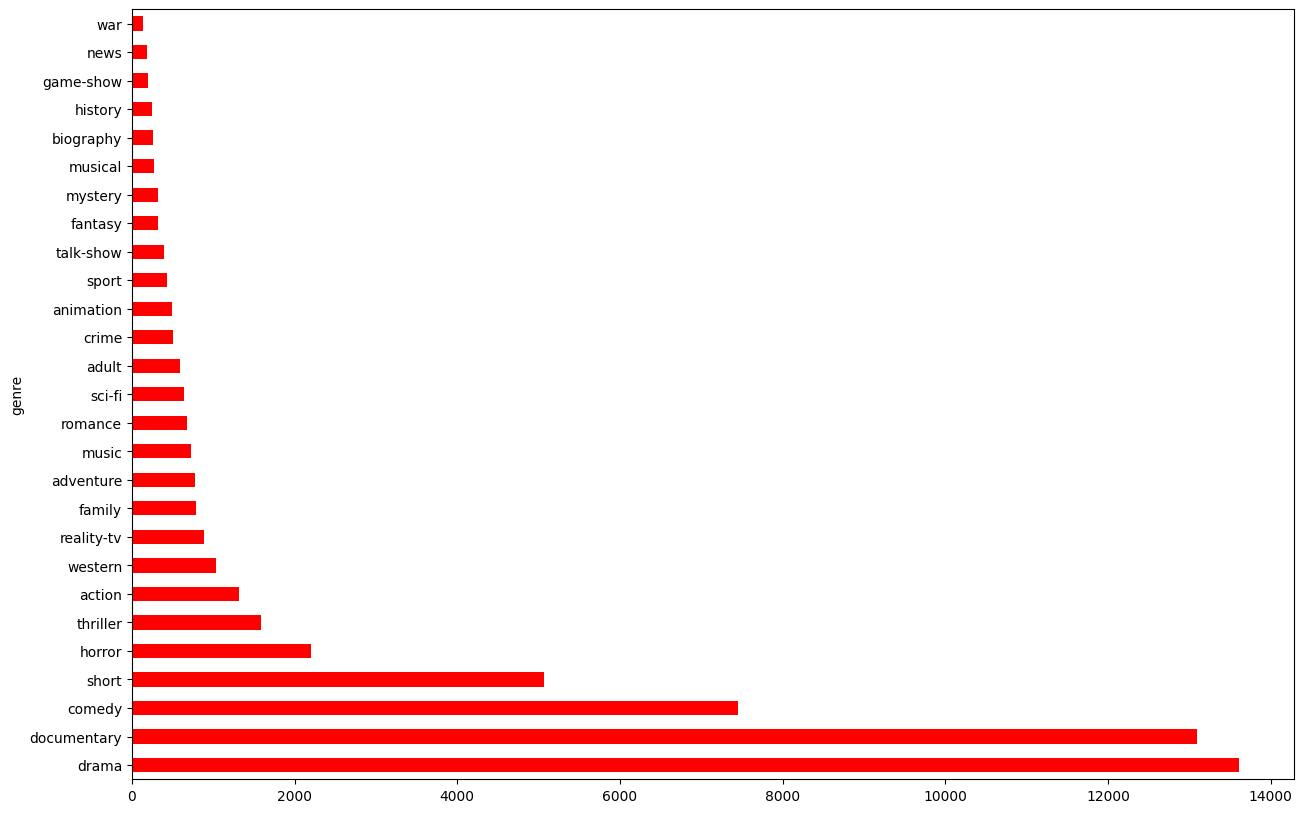

time: 422 ms (started: 2024-06-07 15:35:33 +00:00)


In [ ]:
test_df['genre'].value_counts().plot(kind="barh",figsize=(15,10),color='red')

In [83]:
for i in range(2):
    print(f'Description: {X_sol_text[i]}')
    print(f'True Genre: {Y_sol[i]}')
    print('---')

Description: L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.
True Genre: thriller
---
Description: Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina's birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and the old housemaid. The rest of

In [84]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_sol_text)
X_sol = tokenizer.texts_to_sequences(X_sol_text)
max_length = 200
X_sol = pad_sequences(X_sol, maxlen=max_length, padding='post', truncating='post')

time: 10.6 s (started: 2024-06-08 04:33:09 +00:00)


### **Model predection**

In [ ]:
predictions = model.predict(X_sol)

1694/1694 [==============================] - 16s 9ms/step
time: 21.2 s (started: 2024-06-07 15:35:50 +00:00)


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_genres = LB.inverse_transform(predicted_classes)

for i in range(30):
    print(f'Description: {X_sol_text[i]}')
    print(f'True Genre: {Y_sol[i]}')
    print(f'Predicted Genre: {predicted_genres[i]}')
    print('---')

Description: L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.
True Genre: thriller
Predicted Genre: documentary
---
Description: Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina's birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and t

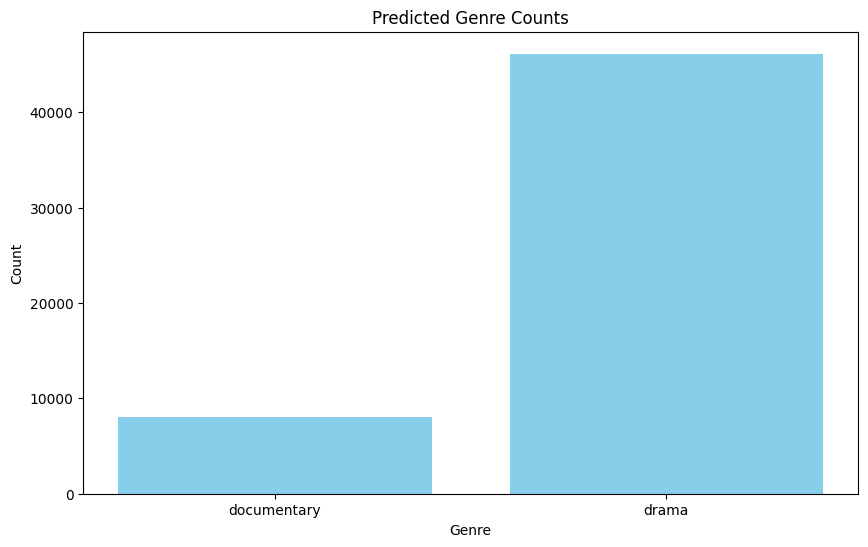

time: 511 ms (started: 2024-06-07 15:36:34 +00:00)


In [ ]:
from collections import Counter

genre_counts = Counter(predicted_genres)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.title('Predicted Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


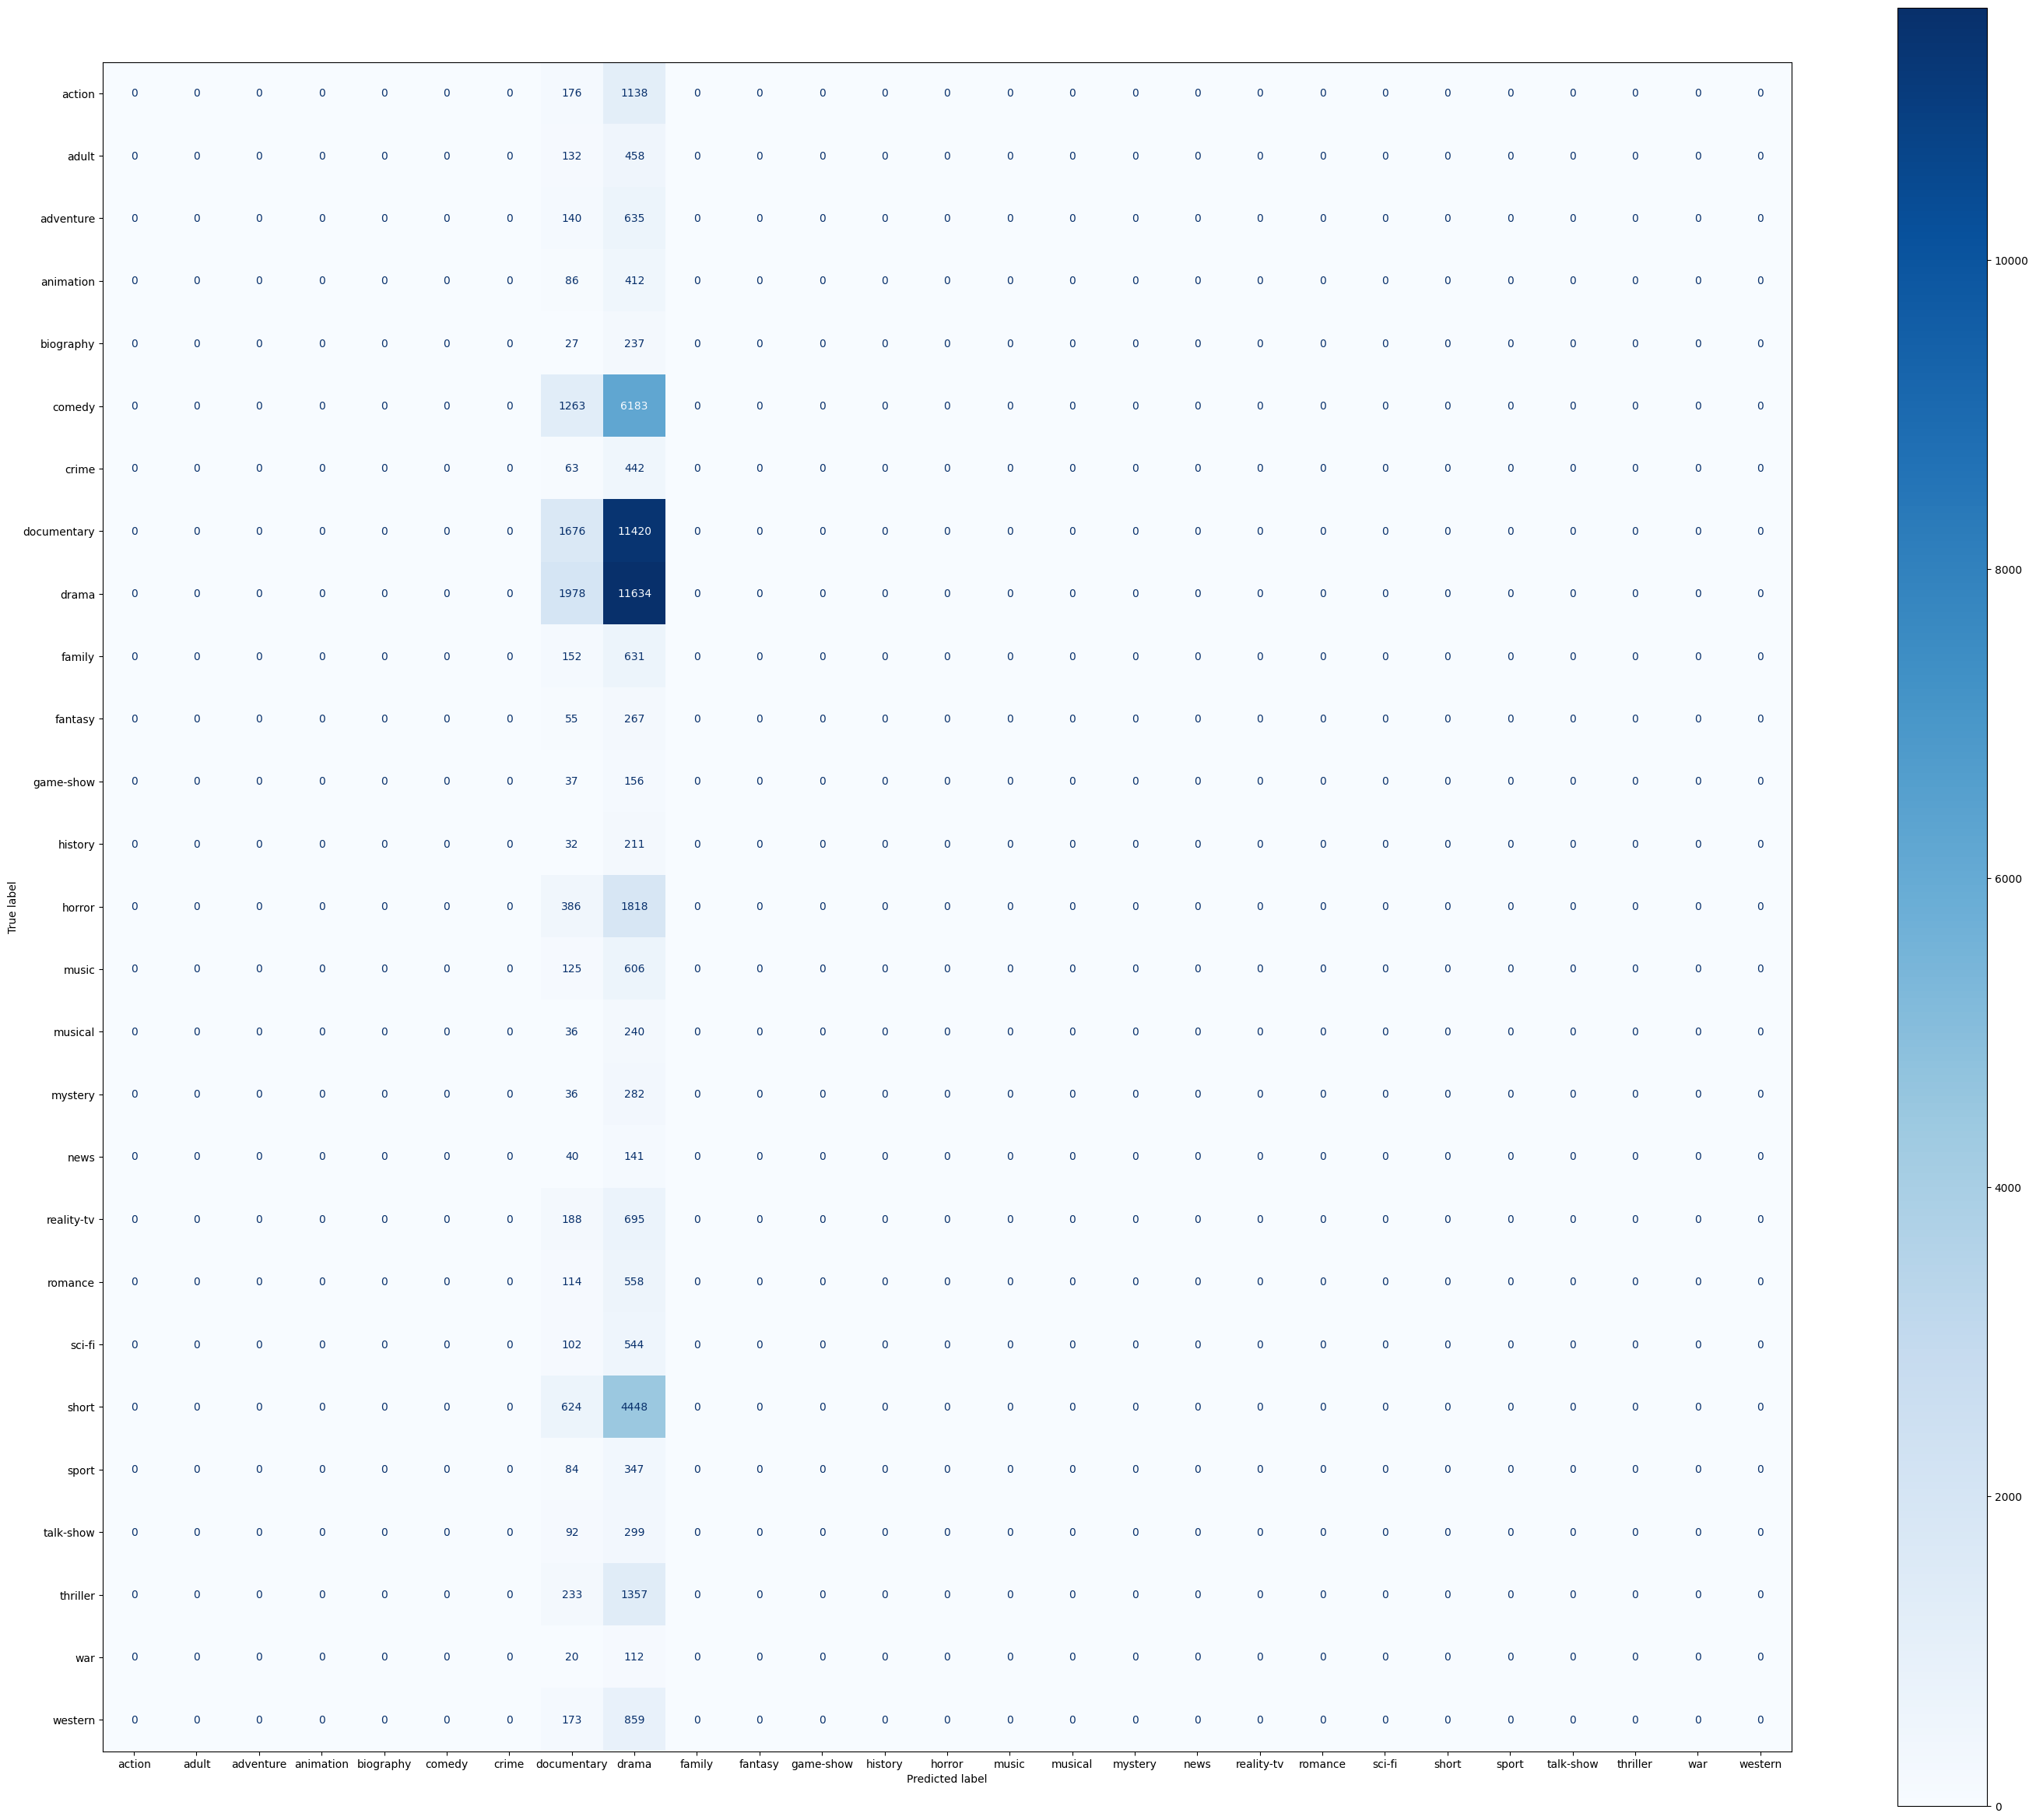

time: 2.6 s (started: 2024-06-07 15:36:12 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(Y_sol,predicted_genres)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.classes_)
fig, ax = plt.subplots(figsize=(35, 30))
display.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

### **Model2 predection**

In [85]:
predictions2 = model2.predict(X_sol)

1694/1694 [==============================] - 31s 17ms/step
time: 42.2 s (started: 2024-06-08 04:33:23 +00:00)


In [86]:
predicted_classes = np.argmax(predictions2, axis=1)
predicted_genres = LB.inverse_transform(predicted_classes)

for i in range(30):
    print(f'Description: {X_sol_text[i]}')
    print(f'True Genre: {Y_sol[i]}')
    print(f'Predicted Genre: {predicted_genres[i]}')
    print('---')

Description: L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.
True Genre: thriller
Predicted Genre: drama
---
Description: Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina's birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and the old

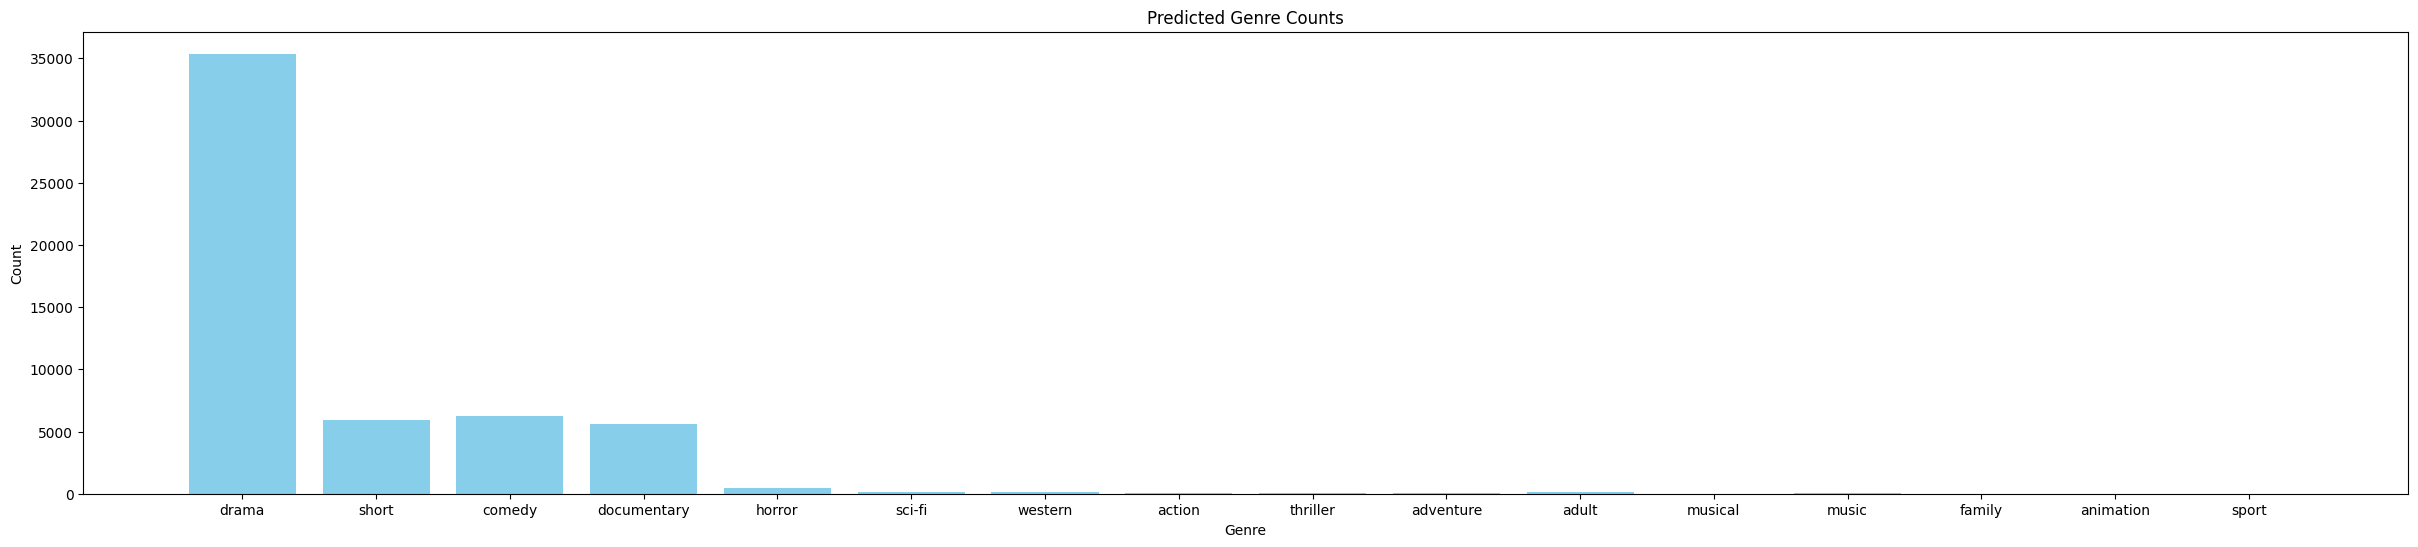

time: 360 ms (started: 2024-06-08 04:34:05 +00:00)


In [87]:
from collections import Counter

genre_counts = Counter(predicted_genres)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(30, 6))
plt.bar(genres, counts, color='skyblue')
plt.title('Predicted Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


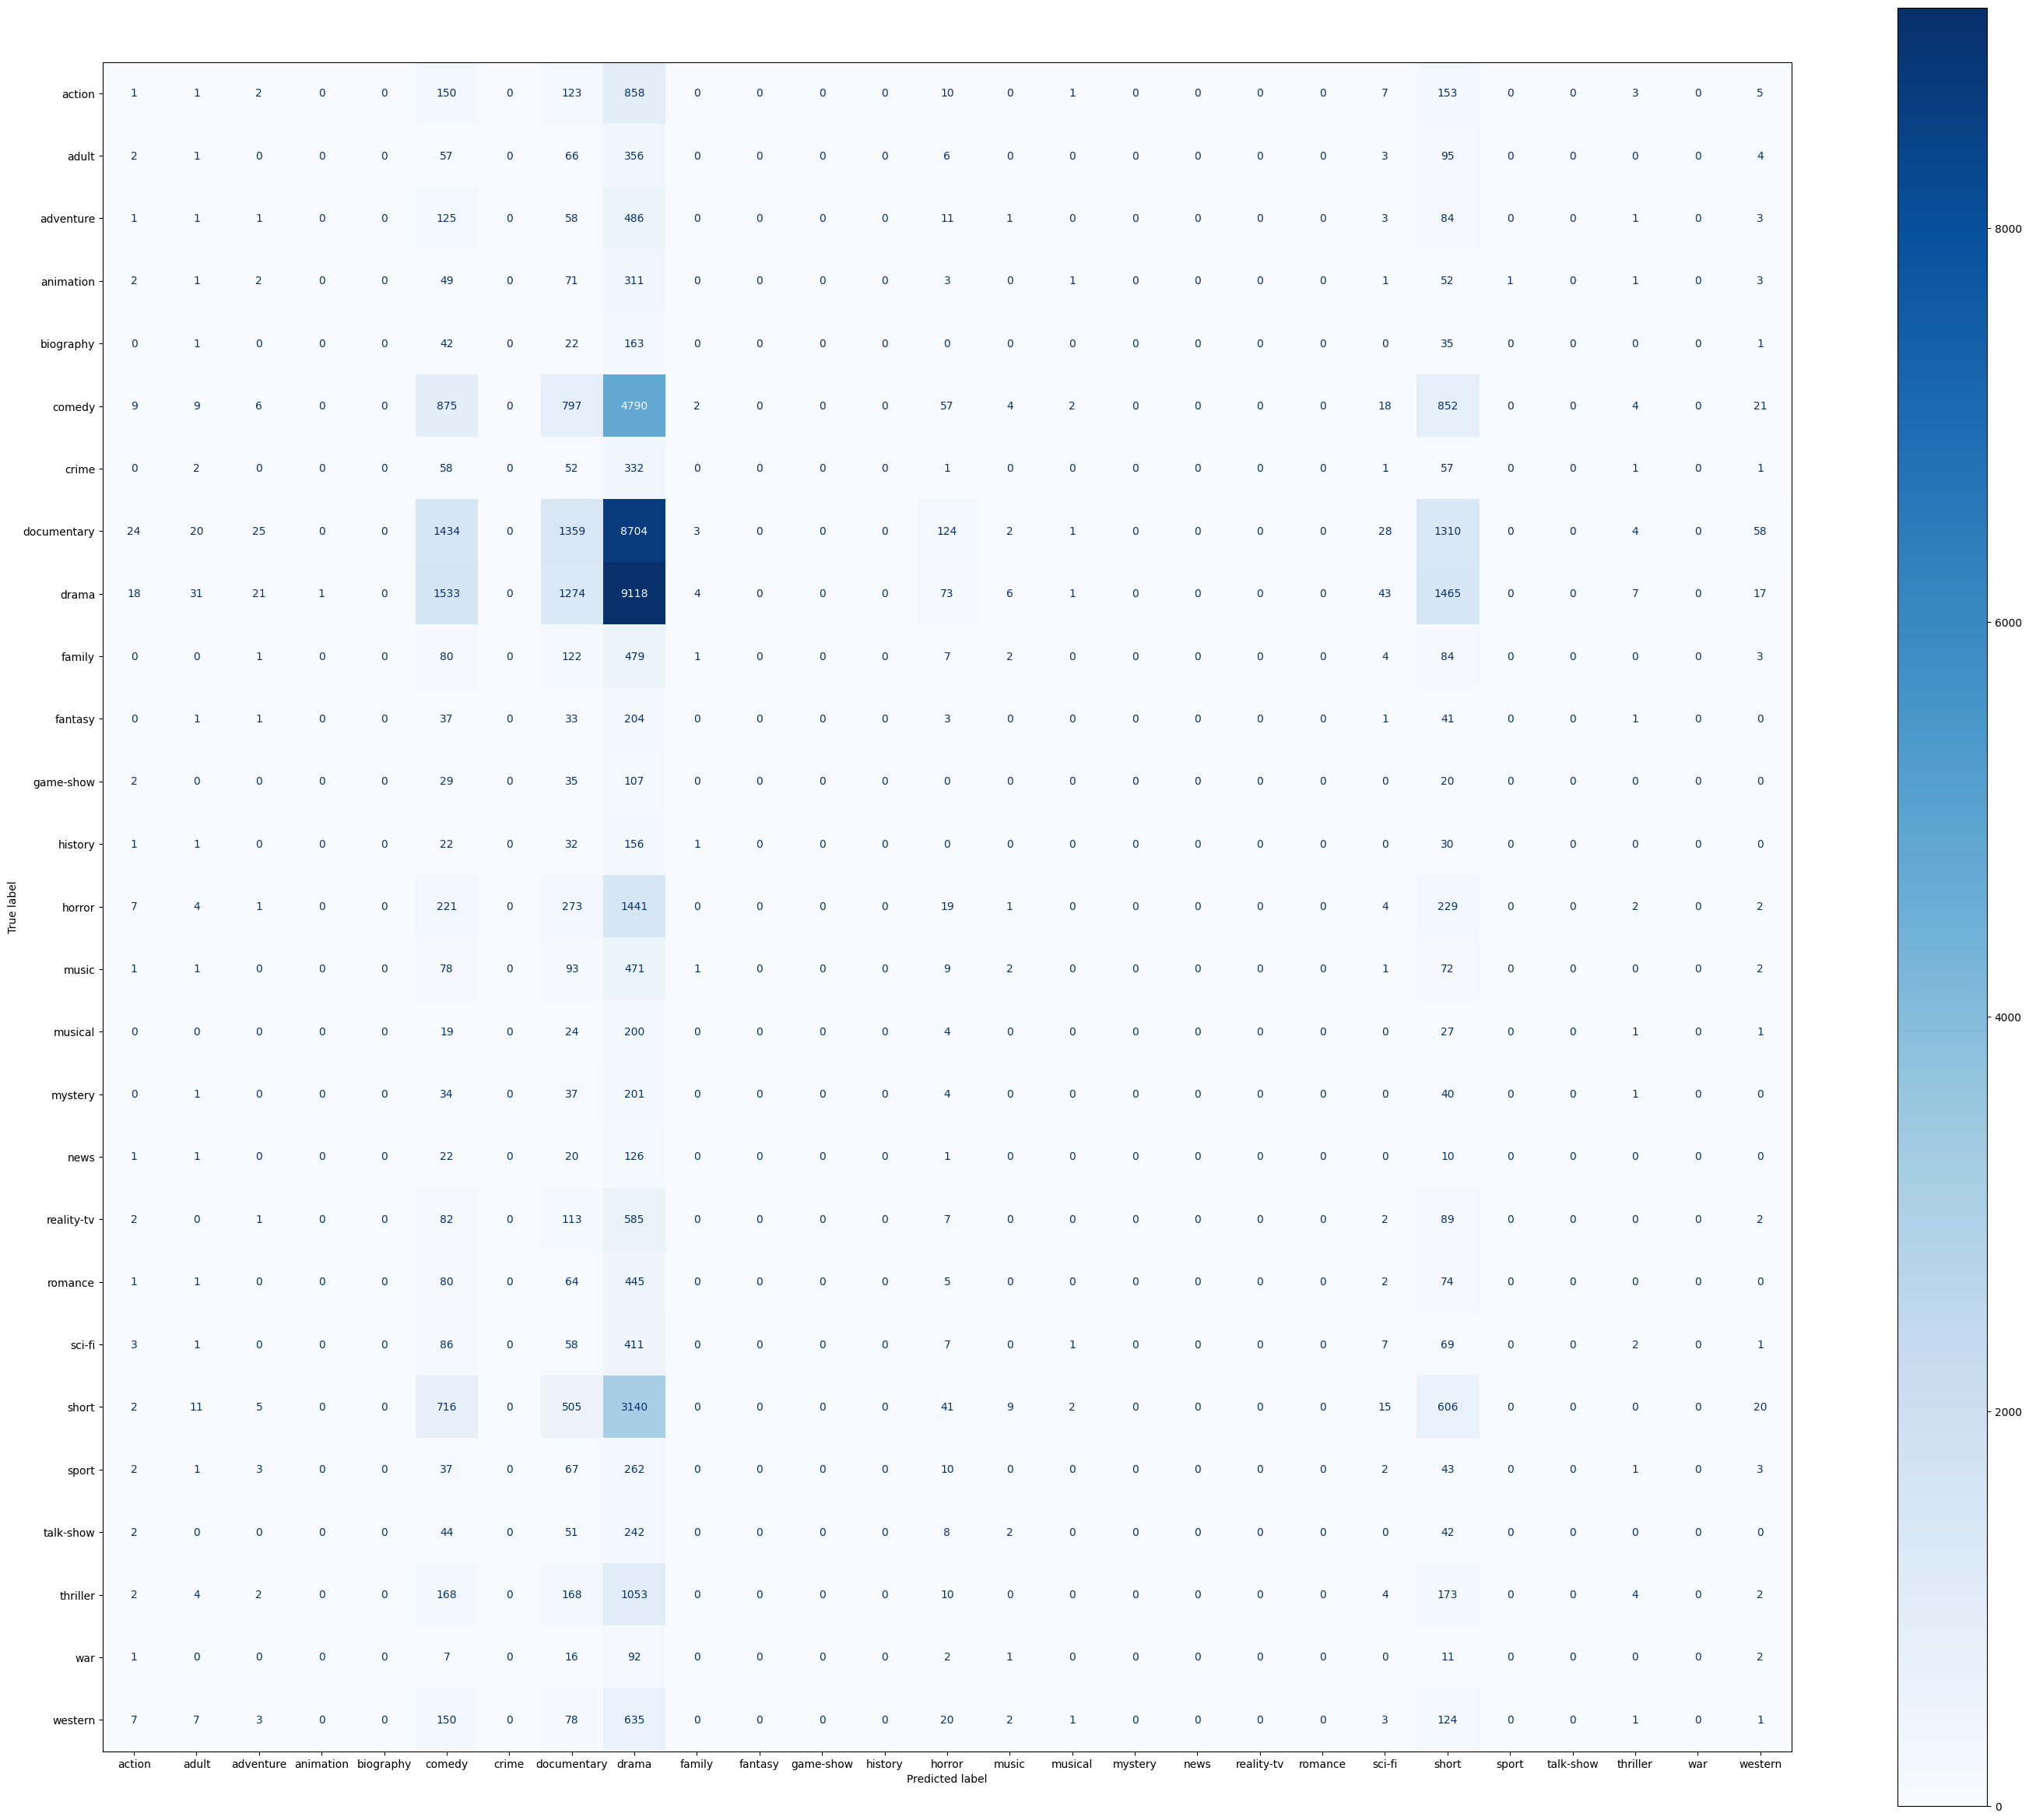

time: 3.05 s (started: 2024-06-08 04:34:06 +00:00)


In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(Y_sol,predicted_genres)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.classes_)
fig, ax = plt.subplots(figsize=(35, 30))
display.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

### **Support Vector Machines prediction**

In [ ]:
with tf.device('/device:GPU:0'):
    y_pred = svm.predict(X_pre_sol)


    accuracy = accuracy_score(Y_pre_sol, y_pred)
    report = classification_report(Y_pre_sol, y_pred)

    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.27215252152521524
Classification Report:
              precision    recall  f1-score   support

      action       0.10      0.01      0.02      1023
       adult       0.10      0.02      0.03       452
   adventure       0.02      0.00      0.00       580
   animation       0.05      0.00      0.01       373
   biography       0.00      0.00      0.00       194
      comedy       0.20      0.26      0.23      5563
       crime       0.00      0.00      0.00       383
 documentary       0.35      0.48      0.41      9863
       drama       0.32      0.39      0.35     10136
      family       0.17      0.00      0.00       579
     fantasy       0.00      0.00      0.00       233
   game-show       0.00      0.00      0.00       142
     history       0.00      0.00      0.00       184
      horror       0.17      0.03      0.06      1627
       music       0.14      0.01      0.01       546
     musical       0.00      0.00      0.00       209
     mystery       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


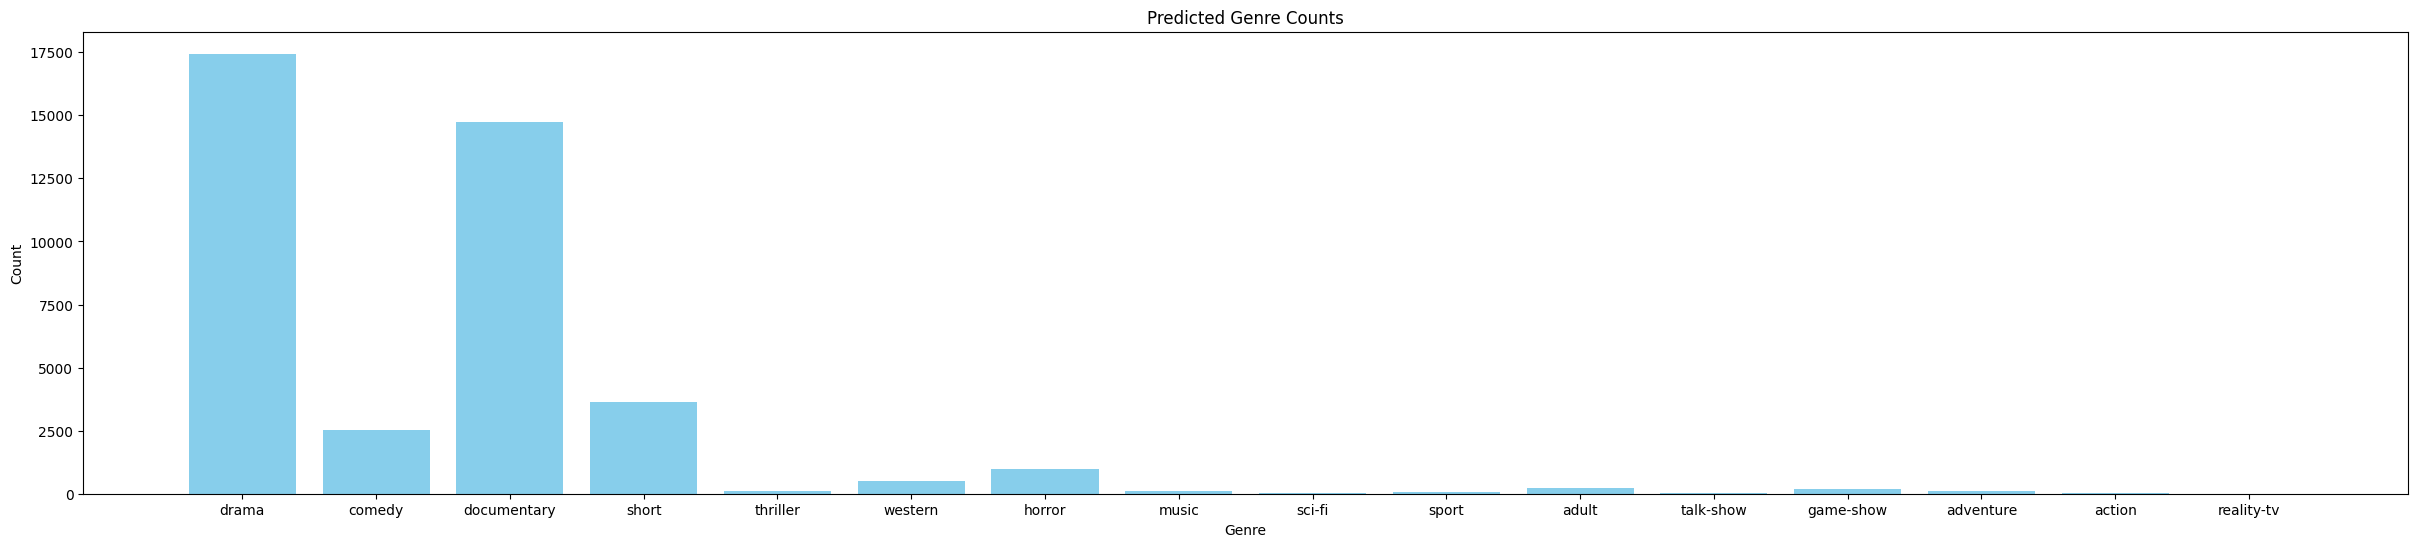

time: 552 ms (started: 2024-06-07 16:08:09 +00:00)


In [ ]:
from collections import Counter

genre_counts = Counter(y_pred)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(30, 6))
plt.bar(genres, counts, color='skyblue')
plt.title('Predicted Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


### **Random Forest predection**

In [ ]:
y_pred_rf = rf.predict(X_pre_sol)

accuracy = accuracy_score(Y_pre_sol, y_pred)
report = classification_report(Y_pre_sol, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3134071340713407
Classification Report:
              precision    recall  f1-score   support

      action       0.09      0.00      0.00      1023
       adult       0.11      0.05      0.07       452
   adventure       0.00      0.00      0.00       580
   animation       0.00      0.00      0.00       373
   biography       0.00      0.00      0.00       194
      comedy       0.24      0.11      0.15      5563
       crime       0.00      0.00      0.00       383
 documentary       0.38      0.58      0.46      9863
       drama       0.32      0.55      0.41     10136
      family       0.00      0.00      0.00       579
     fantasy       0.00      0.00      0.00       233
   game-show       0.00      0.00      0.00       142
     history       0.00      0.00      0.00       184
      horror       0.16      0.10      0.12      1627
       music       0.11      0.02      0.04       546
     musical       0.00      0.00      0.00       209
     mystery       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


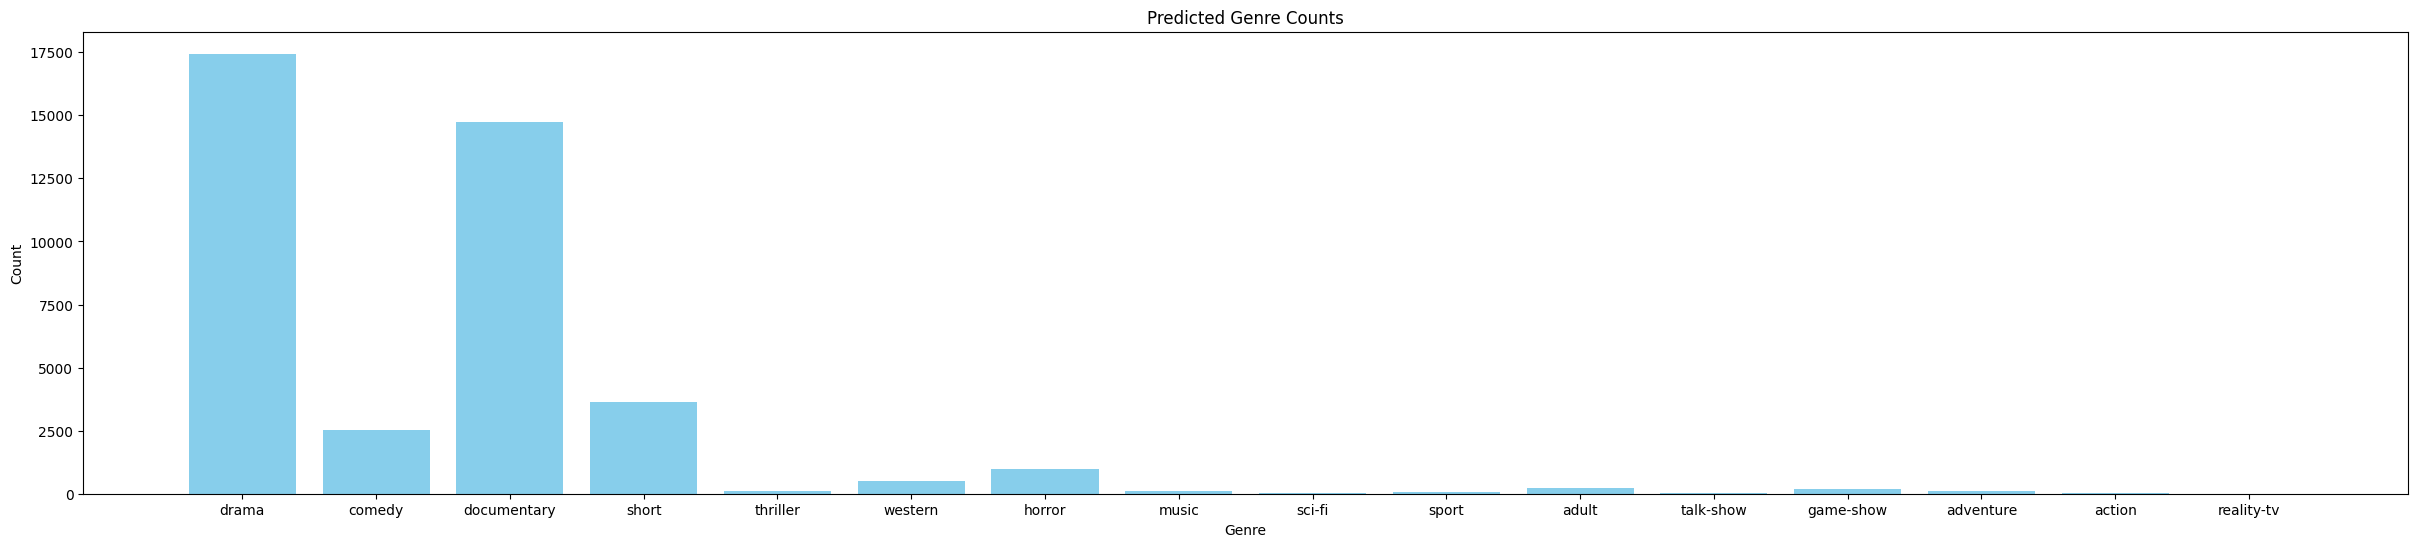

time: 495 ms (started: 2024-06-07 16:09:27 +00:00)


In [ ]:
from collections import Counter

genre_counts = Counter(y_pred_rf)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(30, 6))
plt.bar(genres, counts, color='skyblue')
plt.title('Predicted Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()